<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC581B Final Project
# Inception Network

In [1]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random


In [2]:
# data augmentation transforms
data_augmentation_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=30),
  transforms.RandomCrop(32, padding=2),
  transforms.ColorJitter(brightness=0.25, contrast=0.5, saturation=0.25, hue = 0.15),
  transforms.RandomGrayscale(p=0.2),
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
  transforms.RandomErasing(p=.35),
])

In [3]:
# non-augmentation transform (with data normalization)
normalize_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  )
])

In [4]:
# Load the training data (CIFAR10 to start)
training_data_with_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = data_augmentation_transform,
)

training_data_without_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
training_targets = training_data_with_augmentation.targets

In [6]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [7]:
batch_size = 100

# Create data loaders
train_augmentation_dataloader = DataLoader(training_data_with_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
train_no_augmentation_dataloader = DataLoader(training_data_without_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(validation_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [8]:
train_status = True

In [9]:
if not train_status:
  # Check that it is splitting the data properly
  train_length = 0
  for _, y in train_augmentation_dataloader:
    train_length += len(y)
  print(f"Length of training (augmentation) split: {train_length}")

  train_aug_length = 0
  for _, y in train_no_augmentation_dataloader:
    train_aug_length += len(y)
  print(f"Length of training (no augmentation) split: {train_aug_length}")

  valid_length = 0
  for _, y in valid_dataloader:
    valid_length += len(y)
  print(f"Length of validation split: {valid_length}")

  test_length = 0
  for _, y in test_dataloader:
    test_length += len(y)
  print(f"Length of test split: {test_length}")

Length of training (augmentation) split: 40000
Length of training (no augmentation) split: 40000
Length of validation split: 10000
Length of test split: 10000


In [10]:
if not train_status:
  # Check that there are 100 instances of a random class in the validation set
  count = 0
  test_class = random.randint(0,99)
  for _, y in valid_dataloader:
    for target in y:
      if int(target.numpy()) == test_class:
        count += 1

  print(count)

100


# Building Inception Network

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Inception (GoogLeNet) architecture

- Input: 224x224x3
- block 1
  - conv
    - 7x7 / stride=2
    - pad=3
    - dim - 112x112x64
  - max pool
    - 3x3 / stride=2
    - dim - 56x56x64
-block 2
  - conv
    - 3x3 / stride=1
    - pad=1
    - dim - 56x56x192
  - max pool
    - 3x3 / stride=2
    - dim - 28x28x192
- inception 3a
- inception 3b
- max pool
  - 3x3 / stride=2
  - dim - 14x14x480
- inception 4a
  - dim - 14x14x512
- inception 4b
- inception 4c
- inception 4d
- inception 4e
  - dim - 14x14x832
- max pool
  - 3x3 / stride=2
  - dim - 7x7x832
- inception 5a
- inception 5b
  - dim - 7x7x1024
- avg pool
  - 7x7 / stride=1
  - dim - 1x1x1024
- dropout (p=0.4)
- linear
  - dim - 1x1x1000 (need to substitute 100 for CIFAR)
- softmax

In [83]:
# define the inception block architecture
class Inception_block(nn.Module):
  def __init__(self, input_channels, out_1, reduce_3, out_3, reduce_5, out_5, out_pool):
    super(Inception_block, self).__init__()

    self.conv_1 = nn.Sequential(
        nn.Conv2d(input_channels, out_1, kernel_size=1),
        nn.BatchNorm2d(out_1),
        nn.ReLU(),
    )
    self.conv_3 = nn.Sequential(
        nn.Conv2d(input_channels, reduce_3, kernel_size=1),
        nn.BatchNorm2d(reduce_3),
        nn.ReLU(),
        nn.Conv2d(reduce_3, out_3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_3),
        nn.ReLU(),
    )
    self.conv_5 = nn.Sequential(
        nn.Conv2d(input_channels, reduce_5, kernel_size=1),
        nn.BatchNorm2d(reduce_5),
        nn.ReLU(),
        nn.Conv2d(reduce_5, out_5, kernel_size=5, padding=2),
        nn.BatchNorm2d(out_5),
        nn.ReLU()
    )
    self.maxpool = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(input_channels, out_pool, kernel_size=1),
        nn.BatchNorm2d(out_pool),
        nn.ReLU(),
    )



  def forward(self, x):
    out = torch.cat([self.conv_1(x), self.conv_3(x), self.conv_5(x), self.maxpool(x)], dim=1)
    return out

In [93]:
# define the model
class InceptionNet(nn.Module):
  def __init__(self, name='InceptionNet'):
    super(InceptionNet, self).__init__()
    self.name = name
    
    self.block1 = nn.Sequential(
        # In shape: 224x224x3
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), # out shape: 112x112
        nn.BatchNorm2d(64), # not part of original Inception network, but that's because it didn't exist at the time
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        # out shape: 56x56x64
    )
    self.block2 = nn.Sequential(
        # in shape: 56x56x64
        nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(192),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
        # out shape: 28x28x192
    )
    
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32) # out_channels = 256
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64) # out_channels = 480
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # out shape: 14x14
    
    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64) # out_channels = 512
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64) # out_channels = 528
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128) # out_channels = 832
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # out shape: 7x7

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128) # out_channels = 1024

    self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1) #out shape: 1x1x1024
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.4),
        nn.Linear(1024,100)
    )


  def forward(self, x):
    out = self.block1(x)
    out = self.block2(out)
    out = self.inception3a(out)
    out = self.inception3b(out)
    out = self.maxpool3(out)
    out = self.inception4a(out)
    out = self.inception4b(out)
    out = self.inception4c(out)
    out = self.inception4d(out)
    out = self.inception4e(out)
    out = self.maxpool4(out)
    out = self.inception5a(out)
    out = self.inception5b(out)
    out = self.fc(out)

    return out

In [94]:
# Training function
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track train_loss and accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [95]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [96]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [97]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step(val_loss)

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
  else:
    print()

  return train_losses, train_accuracies, val_losses, val_accuracies

# Training

In [201]:
n_epochs = 100

In [202]:
model = InceptionNet().to(device)
num_param = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_param:,}")

Total number of parameters: 6,086,324


In [203]:
model_aug = InceptionNet().to(device)
num_param = sum(p.numel() for p in model_aug.parameters())
print(f"Total number of parameters: {num_param:,}")

Total number of parameters: 6,086,324


In [204]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn_aug = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=4)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_aug, mode='min', patience=4)

In [205]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model, train_no_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer, scheduler, early_stopping=True, patience=20)


Epoch 1
----------------------------
loss: 4.723020 [    0/40000]
loss: 4.351018 [10000/40000]
loss: 3.927886 [20000/40000]
loss: 3.909718 [30000/40000]
Validation Error: 
 Validation accuracy: 13.4%, Validation loss: 3.736977 

Storing new best model.

Epoch 2
----------------------------
loss: 3.611068 [    0/40000]
loss: 3.744743 [10000/40000]
loss: 3.600710 [20000/40000]
loss: 3.501087 [30000/40000]
Validation Error: 
 Validation accuracy: 19.1%, Validation loss: 3.406508 

Storing new best model.

Epoch 3
----------------------------
loss: 3.262960 [    0/40000]
loss: 3.125734 [10000/40000]
loss: 3.510571 [20000/40000]
loss: 3.447448 [30000/40000]
Validation Error: 
 Validation accuracy: 22.2%, Validation loss: 3.200815 

Storing new best model.

Epoch 4
----------------------------
loss: 2.915765 [    0/40000]
loss: 3.127268 [10000/40000]
loss: 3.062268 [20000/40000]
loss: 2.913938 [30000/40000]
Validation Error: 
 Validation accuracy: 24.7%, Validation loss: 3.047893 

Storing 

### LR results after 3 epochs
- `1e-1` => no learning
- `1e-2` => 6.9% / 3.960389
- `1e-3` => 19.6% / 3.241354
- `3e-4` => 25.8% / 3.016752
- `2e-4` => 25.2% / 3.026053
- `1e-4` => 21.9% / 3.216289
- `5e-5` => 17.5% / 3.492415
- `1e-5` => 7.8% / 4.220170

<function matplotlib.pyplot.show>

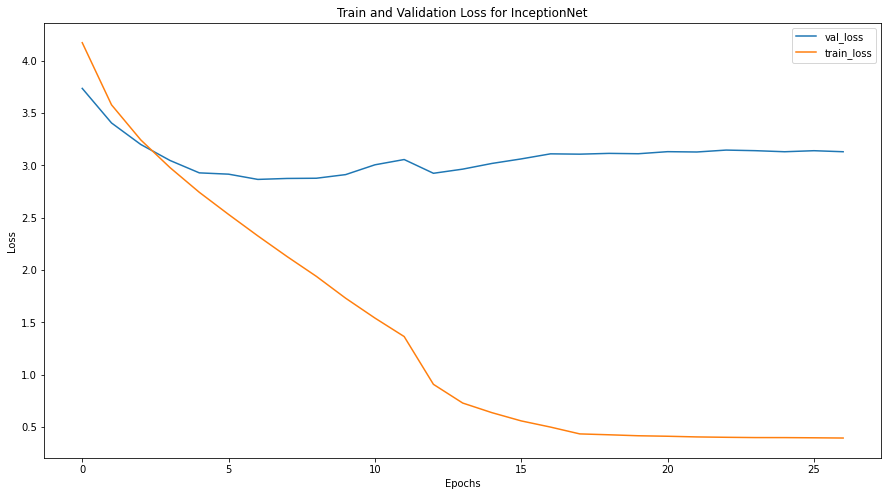

In [206]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

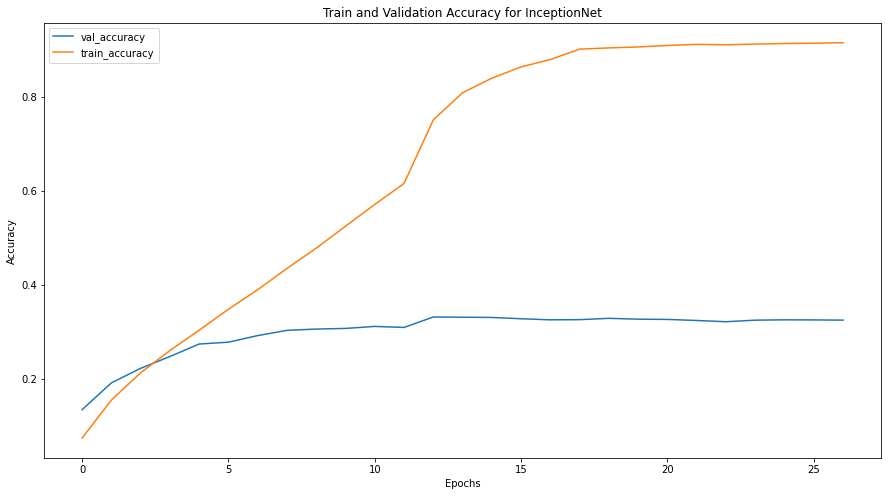

In [207]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [208]:
train_loss_aug, train_accuracy_aug, val_loss_aug, val_accuracy_aug = training_loop(n_epochs, model_aug, train_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn_aug, optimizer_aug, scheduler_aug, early_stopping=True, patience=20)


Epoch 1
----------------------------
loss: 4.781817 [    0/40000]
loss: 4.591547 [10000/40000]
loss: 4.600745 [20000/40000]
loss: 4.298219 [30000/40000]
Validation Error: 
 Validation accuracy: 7.5%, Validation loss: 4.107922 

Storing new best model.

Epoch 2
----------------------------
loss: 4.209004 [    0/40000]
loss: 4.299364 [10000/40000]
loss: 4.170458 [20000/40000]
loss: 4.213579 [30000/40000]
Validation Error: 
 Validation accuracy: 9.6%, Validation loss: 3.910773 

Storing new best model.

Epoch 3
----------------------------
loss: 4.106161 [    0/40000]
loss: 4.098024 [10000/40000]
loss: 3.919179 [20000/40000]
loss: 4.112504 [30000/40000]
Validation Error: 
 Validation accuracy: 12.8%, Validation loss: 3.715884 

Storing new best model.

Epoch 4
----------------------------
loss: 4.203766 [    0/40000]
loss: 3.994432 [10000/40000]
loss: 4.084821 [20000/40000]
loss: 4.056208 [30000/40000]
Validation Error: 
 Validation accuracy: 13.7%, Validation loss: 3.644516 

Storing ne

<function matplotlib.pyplot.show>

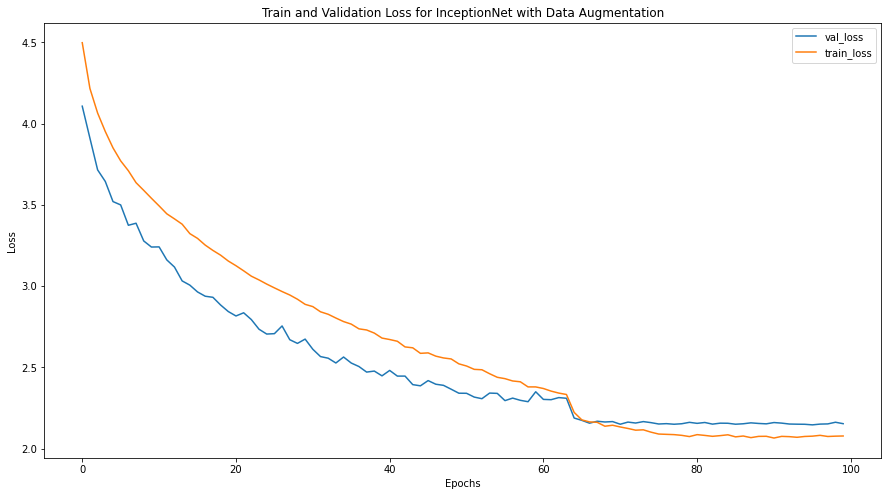

In [212]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name} with Data Augmentation")
plt.plot(val_loss_aug, label="val_loss")
plt.plot(train_loss_aug, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

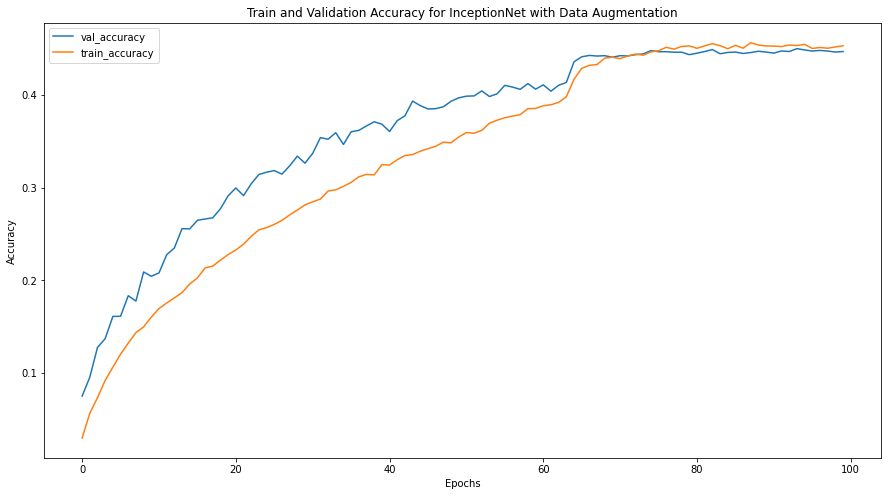

In [211]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name} with Data Augmentation")
plt.plot(val_accuracy_aug, label="val_accuracy")
plt.plot(train_accuracy_aug, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show